# day 3 tutorial

Run the whole notebook by selecting "Restart & Run All" from the "Kernel" menu (above).

**TO RUN LOCALLY users need to install ipywidgets and ipyleaflet and enable the widget extension for jupyter:**
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```
**notes:**
* old code that Yaxing might still want to use is at bottom


In [1]:
# core Python 3
import os
import json
from io import StringIO

import requests
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import ipywidgets as wg
import ipyleaflet as mwg
import matplotlib.pyplot as plt
from matplotlib import cm, colors


# some dev settings
import warnings
warnings.filterwarnings('ignore')
user_num = 32863                # ORNL_DAAC_USER_NUM for jack's URS acct
save_samples = None #"sites/samples/" # if None, SMV downloads won't be saved; else path

## SMV Datasets

[*docs/smvdatasets.csv*](docs/smvdatasets.csv) is a copy of the datasets table from the [SMV User Guide](https://daac.ornl.gov/soilmoisture/guide.html). Read it into a `pandas` data frame and display it:

In [2]:
smvds = pd.read_csv("docs/smvdatasets.csv", index_col="dataset", header=0)
smvds

,source,type,units,description,soil_zone,soil_depth,native_res,time_coverage
dataset,,,,,,,,
SoilSCAPE_surface,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"5, 20, 50 cm",point,2011-present
SoilSCAPE_rootzone,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"5, 20, 50 cm",point,2011-present
AirMOSS_in-ground_surface,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
AirMOSS_in-ground_rootzone,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
COSMOS_surface,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,0-30 cm,point,2008-present
COSMOS_rootzone,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,0-30 cm,point,2008-present
AirMOSS_L2_3_surface,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0 cm,surface,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L2_3_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-30cm,rootzone,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L4_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-100cm,rootzone,"0-10, 10-40, 40-100 cm",90-m,2012-2015


## Download a SMV dataset with `requests`
Example: 
https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=30&ln=-100&d=smap

**The SMV data from the url above can be downloaded with the `requests` package:**
```{python}
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?"
inlat, inlon = 30, -100

r = requests.get(
    "".join([url, "lt=", str(inlat), "&ln=", str(inlon), "&d=smap"]),
    cookies=dict(ORNL_DAAC_USER_NUM="10"))
```

**The response text can be passed to `pandas.read_csv()` as a pseudo-file using `io.StringIO()`:**
```{python}
lat, lon = StringIO(r.text).readlines()[2].split("Location: ")[1].strip().split(", ")
df = pd.read_csv(StringIO(r.text), header=4, index_col="time")
```
**We read from TXT file for now because I've been abusing the SMV service with my testing:**

In [3]:
example_dataset = "sites/samples/daily-smap-ORNL-DAAC-PccIuo.txt"

# the latitude and longitude are returned in the txt header; grab them:
with open(example_dataset, "r") as f:
    lat, lon = f.readlines()[2].split("Location: ")[1].strip().split(", ")
    
# the data are in lines 4 -> end; read into pandas df; print first 10 rows
df = pd.read_csv(example_dataset, header=4, index_col="time")
df.index = pd.to_datetime(df.index)
df.head(10)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
2012-09-20,;;,;;,;nan;,;7.2;,4.86;7.16;9.2,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-21,;;,;;,;;,;;,9.55;9.6;9.67,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-22,;;,;;,;;,;;,9.34;9.49;9.57,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-23,;;,;;,;;,;;,9.14;9.38;9.52,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-24,;;,;;,;;,;;,8.95;9.27;9.49,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;19.59;,;36.24;,;;,;;
2012-09-25,;;,;;,;;,;;,8.79;9.18;9.46,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-26,;;,;;,;;,;;,8.65;9.09;9.43,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-27,;;,;;,;;,;;,8.53;9.02;9.4,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-28,;;,;;,;;,;;,8.6;9.01;9.38,;;,;;,;;,;;,0.0;0.13;8.0,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;


---------------------------------
## Prepare functions to batch process SMV sample downloads

The next several cells show how to convert the text response from the Soil Moisture Visualizer into an `xarray.Dataset` object. `xarray` is part of the PyData ecosystem and takes advantage of `numpy` and `pandas` core functionality to provide intuitive storage and processing of n-dimensional arrays, in ways that many users in the geosciences will find familiar.

### function 1: Request SMV data and parse to `pandas.DataFrame`
function below combines the two steps above. We'll use it to submit a series of requests for data from the SMV later in the tutorial:

In [4]:
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?lt={lat}&ln={lon}&d={d}"  # url string

def smvrequest(id, lon, lat, d="smap", save=save_samples):
    
    r = requests.get(                                               # submit the request
        url.format(lat=lat, lon=lon, d=d),                          # format the url string
        cookies=dict(ORNL_DAAC_USER_NUM=str(user_num)))             # pass DAAC cookie

    df = pd.read_csv(StringIO(r.text), header=4, index_col="time")  # response -> pandas df
    df.index = pd.to_datetime(df.index)                             # dates -> pd.datetimes
    
    if save:                                                        # optionally, save .txt
        fn = ["sample",str(id),str(lat),str(lon),".txt"]            # filename components
        df.to_csv(save+"_".join(fn))                                # save pandas df to csv
    
    return(df)

### functions 2, 3, 4: Reformat SMV data as a netCDF-like `xarray.Dataset`
Several functions are defined below to simplify conversion of the SMV outputs to an `xarray.Dataset`. They rely entirely on functionality from `pandas` and `xarray`:
2. **getxr** - splits the `min,mean,max` strings in each column of the SMV output into an `xarray.Dataset` containing three `xarray.DataArrays`
3. **getsample** - returns three arrays that help to describe the spatial properties of the sampled point (sample [*coordinate*], lat [*y variable*], lon [*x variable*])
4. **getatts** - returns a dictionary of global (file-level) attributes


In [5]:
# returns the count of not-nan values in an array:
getcount = lambda x: np.nonzero(np.isnan(x.data))[0].size

def getxr(series): # 2
    """
    This function parses the input pandas series (type=string) into 
    a pandas df with three columns (min, mean, max) and returns 
    them as an xarray.Dataset.
    """

    # split columns into more columns; give names
    t = series.str.split(";", n = 2, expand=True)
    t.columns = [series.name+"_mean", series.name+"_min", series.name+"_max"]

    # replace empty strings w numpy.nan; all dtypes to float
    for col in t.columns:
        t[col].loc[t[col]==''] = np.nan
        t[col] = t[col].astype(float)
        
    # make an xarray.Dataset; add attributes to each array
    x = xr.Dataset(t)
    for col in list(t):
        x[col].attrs = smvds.loc[series.name].to_dict()
        x[col].attrs["count"] = getcount(x[col])
    
    return(x)
    
    
def getsample(sample=None, lon=None, lat=None): # 3
    """
    This function takes an input sample id (integer), latitude (float),
    and longitude (float), and returns four xarray.DataArrays that 
    describe the location of the sampled point.
    """
    
    # make an array with length == 1 for sample dimension
    sample = xr.DataArray(data=[sample], dims=["sample"])
    
    # make a label to describe the sample dimension
    sample_name = xr.DataArray(
        data=["sample"+("%02d" % sample)], 
        dims=["sample"],
        attrs=dict(
            long_name="sample name", 
            cf_role="timeseries_id"))

    # make a latitude coordinate array
    lat = xr.DataArray(
        data=[float(lat)], 
        coords=[sample], 
        dims=["sample"], 
        attrs=dict(
            standard_name = "latitude",
            long_name = "sample latitude",
            units = "degrees_north"))
    
    # make a longitude coordinate array
    lon = xr.DataArray(
        data=[float(lon)], 
        coords=[sample], 
        dims=["sample"], 
        attrs=dict(
            standard_name = "longitude",
            long_name = "sample longitude",
            units = "degrees_east"))
    
    return((sample, sample_name, lat, lon))


def getatts(dataset): # 4
    """Returns dataset attributes from smvdataset.csv."""
    
    atts = smvds.loc[dataset].to_dict()
    atts.update({"dataset": dataset, "featureType": "timeSeries"})
    return(atts)


c = getsample(sample=0, lat=lat, lon=lon)       # get coordinate arrays
ds = getxr(df['SMAP_rootzone'])                 # get xarray.Dataset
ds["sample_name"], ds['lat'], ds['lon'] = c[1:] # add coords to dataset
ds.attrs = getatts('SMAP_rootzone')             # add attributes
ds

<xarray.Dataset>
Dimensions:             (sample: 1, time: 2354)
Coordinates:
  * sample              (sample) int32 0
  * time                (time) datetime64[ns] 2012-09-20 ... 2019-03-01
Data variables:
    SMAP_rootzone_mean  (time) float64 nan nan nan nan ... 15.78 15.76 15.66
    SMAP_rootzone_min   (time) float64 nan nan nan nan ... 15.81 15.88 15.73
    SMAP_rootzone_max   (time) float64 nan nan nan nan ... 15.86 15.93 15.78
    sample_name         (sample) <U8 'sample00'
    lat                 (sample) float64 31.81
    lon                 (sample) float64 -110.4
Attributes:
    source:         SMAP
    type:           spaceborne
    units:          m3/m3
    description:    Mean vol (%) soil moisture at 0-100cm 
    soil_zone:      rootzone
    soil_depth:     0-5, 0-100 cm
    native_res:     9000-m 
    time_coverage:  2015-present
    dataset:        SMAP_rootzone
    featureType:    timeSeries

`xarray` wraps `matplotlib` to provide quick plotting functionality:

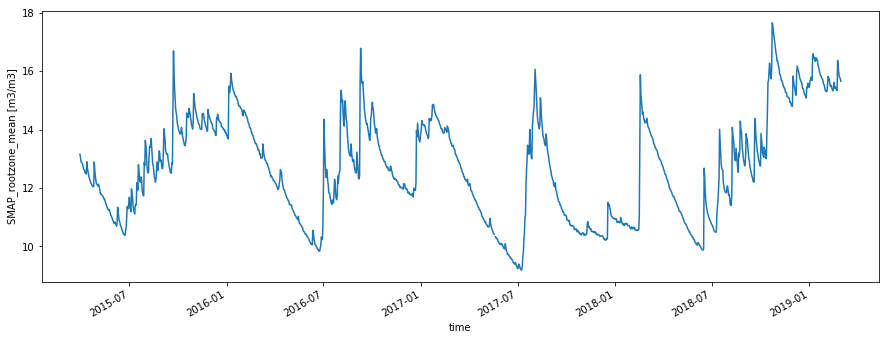

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

ds["SMAP_rootzone_mean"].plot()

The `xarray.Dataset` is easily saved as a netCDF:

In [7]:
ds.to_netcdf("SMAP_rootzone-example.nc")  # save to a netcdf
r, df, c, ds = None, None, None, None     # remove old data

## EASE Grid

Spatial queries to the Soil Moisture Visualizer return data corresponding to 9- by 9-km cells within the EASE grid system. Read about the EASE grid at the NSIDC's web page: https://nsidc.org/data/ease

The next two cells show how to select arrays of EASE grid sample points that fall within an input polygon so that they can be used to submit a series of data requests to the SMV. We will combine everything into one more function (**get_ease**) to use later in our batch processing routine.
      
**Two binary files contain the arrays corresponding to global EASE grid centroid latitudes and longitudes, respectively. Open the two files and read into `numpy` arrays:**

In [8]:
lats = "docs/EASE2_M09km.lats.3856x1624x1.double"
lons = "docs/EASE2_M09km.lons.3856x1624x1.double"

lat_array = np.fromfile(lats, dtype=np.float64).flatten() # read lat to np.array
lon_array = np.fromfile(lons, dtype=np.float64).flatten() # read lon to np.array

c = np.dstack((lon_array, lat_array))[0]                  # zip lat, lon
c

array([[-179.9533195 ,   84.6564188 ],
       [-179.85995851,   84.6564188 ],
       [-179.76659751,   84.6564188 ],
       ...,
       [ 179.76659751,  -84.6564188 ],
       [ 179.85995851,  -84.6564188 ],
       [ 179.9533195 ,  -84.6564188 ]])

**Select a 2-dimensional array of EASE grid centroids using some arbitrary latitude, longitude bounds:** 

In [9]:
selection = c[(-90<lon_array) & (lon_array<-85) & (25<lat_array) & (lat_array<30)]
selection

array([[-89.9533195 ,  29.94568162],
       [-89.85995851,  29.94568162],
       [-89.76659751,  29.94568162],
       ...,
       [-85.19190871,  25.02339698],
       [-85.09854772,  25.02339698],
       [-85.00518672,  25.02339698]])

## function 5: return a sample of EASE grid points for an input polygon geometry
uses the logic above to select an array of coordinates within bounding extent of the polygon

In [10]:
def get_ease(geom):
    
    # geom.bounds method returns a tuple of bounding coordinates:
    sel_minlon, sel_minlat, sel_maxlon, sel_maxlat = geom.bounds
    
    # index the xy array with bool conditions based on extent
    sel_ease = c[(sel_minlon<lon_array) & (lon_array<sel_maxlon) & 
                 (sel_minlat<lat_array) & (lat_array<sel_maxlat)]
    
    # further reduce to pts contained within the selected geometry
    sel_ease_poly = [
        pt for pt in sel_ease if geom.contains(Point(pt[0], pt[1]))]
    
    return(sel_ease_poly)

Now we need to take care of one final step before building a UI.

---------------------------------------------
# Reading an ESRI Shapefile data using `geopandas`

+organizing the data to allow for plotting with ipyleaflet:

In [11]:
gdf = gpd.GeoDataFrame.from_file("sites/Sites_lf.shp")   # open shapefile w geopandas
gdf = gdf.to_crs({'init': 'epsg:4326'})                  # reproj to wgs84
gdf['style'] = [{                                        # add column of mpl.cmaps
    'color': colors.rgb2hex(d[0:3]), 
    'fillColor': colors.rgb2hex(d[0:3]), 
    'weight': 1, 'fillOpacity': 0.5
} for d in cm.Set3(np.linspace(0.0,1.0,len(gdf)))]
gdflyr = json.loads(gdf.to_json())                       # make geojson multipoly

gdf.head(1)                                              # display first row of df

,OBJECTID,RANGERDIST,REGION,FORESTNUMB,DISTRICTNU,DISTRICTOR,FORESTNAME,DISTRICTNA,GIS_ACRES,SHAPE_Leng,...,STD_28,STD_29,STD_30,STD_31,STD_32,STD_33,STD_34,STD_35,geometry,style
0,61,99030501010343,03,05,01,030501,Coronado National Forest,Douglas Ranger District,434025.2,3.963602,...,681.52906,446.146563,453.982071,557.405375,339.841942,599.562885,470.501168,343.082608,(POLYGON ((-109.2462605499999 32.0543309500000...,"{'color': '#8dd3c7', 'fillColor': '#8dd3c7', '..."


-----------------------------------------
# Building a UI in Jupyter with `ipywidgets` and `ipyleaflet`
The next couple cells are pretty long, but they provide some nice functionality for interactive query and display of the SMV data. The cell below initializes the widgets that we'll draw in the cells to come:

1. Make `ipyleaflet` map widget
2. Make map layer of USFS sites from the `geopandas` data frame created above
3. Make a submit button to begin sending series of requests to the SMV
4. Make progress bar to monitor progress of the requests

In [12]:
bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
layer = mwg.GeoJSON(data=gdflyr, hover_style={'color': "white","fillOpacity": 0.8}) 

m = mwg.Map(layers=(layer, bmap,), center=(33, -109), zoom=6, scroll_wheel_zoom=True)
submit = wg.Button(description='Submit', disabled=True, button_style='success')
progress_bar = wg.IntProgress(description="Progress: ", layout=wg.Layout(width="95%"))

def get_mpt(x, y):    
    return(mwg.CircleMarker(
        location=(x, y), 
        radius=7,
        stroke=False, 
        fill_opacity=0.6,
        fill_color="black"))

### Add interaction handlers

**layer_click_handler** reacts to user's selection of USFS polygon from polygon layer and does the following:
* makes array of EASE grid sample locations using `get_ease` function from above
* makes a group of point features to add to map
* inits/resets sample container

In [13]:
samples = {"xy": None, "group": mwg.LayerGroup()}
m.add_layer(samples["group"])

def layer_click_handler(**kwargs):
    global gdf
    global samples
    
    if "id" in kwargs.keys():
        id = int(kwargs["id"])
    else:
        return(None)
    
    samples["group"].clear_layers()

    g = gdf.iloc[id]                             # geopandas row
    geom = g["geometry"]
    cent = geom.centroid
    m.center, m.zoom = (cent.y, cent.x), 9       # center, zoom map
    
    samples['xy'] = []
    for i, pt in enumerate(get_ease(geom)):
        samples['xy'].append((pt[1], pt[0]))
        samples["group"].add_layer(get_mpt(pt[1], pt[0]))
    submit.disabled = False
    

layer.on_click(layer_click_handler)              # set layer click callback

**button_click_handler** reacts to user clicking the submit button by iterating over the sample EASE points resulting from the **layer_click_handler** above and submits requests to the SMV, converting the downloaded text to xarray datasets:

In [14]:
def togglept(event, type, coordinates):
    c = (coordinates[1], coordinates[0])
    i = [i for i,pt in samples["pts"].items() if pt["xy"] == c][0]
    if samples["pts"][i]["bool"]:
        samples["pts"][i]["mpt"].opacity = 0.2
        samples["pts"][i]["bool"] = False
    else:
        samples["pts"][i]["mpt"].opacity = 1
        samples["pts"][i]["bool"] = True    
    

def button_click_handler(b):
    global samples
    
    progress_bar.min = 0                          # set min,
    progress_bar.max = len(samples["xy"])   # max, 
    progress_bar.value = 0                        # and reset
    submit.disabled = True                        # disable submit bttn

    data = []                                   #{"id": [], "xy": [], "ds": []}
    for i,xy in enumerate(samples["xy"]):         # loop over sample pts
        progress_bar.value += 1                   # update progress bar
        m.layers[2].layers[i].stroke = True
        m.layers[2].layers[i].color = "white"
        
        df = smvrequest(i, xy[1], xy[0])          # submit request to SMV
        c = getsample(sample=i, lat=xy[1], lon=xy[0])    # get coordinate arrays
        
        datasets = {}
        for col in list(df):                      # loop over response columns
            ds = getxr(df[col])                   # parse col to xr.Dataset
            ds.attrs = getatts(col)               # add attributes
            ds["sample_name"] = c[1]              # samples
            ds['lat'], ds['lon'] = c[2:]          # coordinates            
            datasets[col] = ds                    # add to dict
        
        data.append((i, xy, datasets))

        
submit.on_click(button_click_handler)             # set submit bttn callback

Display the widgets:

In [15]:
wg.VBox([m, wg.HBox([submit, progress_bar])])

In [16]:
            
            samples["pts"][i] = {
                "bool": True,
                "xy": (pt[0], pt[1]),            # lon, lat tuple
                "data": {}}                      # data dict

NameError: name 'pt' is not defined

# Merging all sample points to a single dataset and saving as netCDF
This is how you would concatenate each dataset along the "sample" dimension (see CF Conventions for `featureType: "timeSeries"`) and merge all datasets together:

In [ ]:
# combine samples for each dataset, omitting all-nan
dsmerges = {}
for ds in smvds.index.tolist():
    try:
        dslist = [d["data"][ds] for s,d in samples["pts"].items()]
        dsmerges[ds] = xr.concat(dslist, "sample")
    except:
        print("Failed to concat "+str(ds)+". May be entirely nodata.")

# merge the datasets
complete_dataset = xr.merge(dsmerges.values())
complete_dataset

Save the entire set of sample points to netCDF:

In [ ]:
complete_dataset.to_netcdf("complete_dataset.nc")

## Getting started with the plotting part:

Find a better way to omit time series that are entirely no data. For now this loop works:

In [ ]:
plotseries = {}
for array in complete_dataset:
    if array is "sample_name":
        pass
    else:
        array_mean = complete_dataset[array].mean().data
        if np.isnan(array_mean):
            print("Skipping: "+array)
        else:
            plotseries[array] = complete_dataset[array]

Plot the remainder:

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

fig = plt.figure()
for name, data in plotseries.items():
    if "mean" in name:
        data[0].plot()

plt.ylim(top=50, bottom=-10)
plt.draw()

In [ ]:
        
        #samples["pts"][i]["mpt"].popup = wg.HTML("<br>".join(samplen))
        
        #m.add_layer(samples["pts"][i]["mpt"])
        #samples["pts"][i]["mpt"].on_click(togglept) # set point click callback
        
        samples["pts"][i]["mpt"] = mwg.CircleMarker( # add map pt
            location=(y, x),
            stroke=True,
            stroke_width=2,
            radius=10, 
            color="orange")

In [ ]:
def togglept(event, type, coordinates):
    c = (coordinates[1], coordinates[0])
    i = [i for i,pt in samples["pts"].items() if pt["xy"] == c][0]
    if samples["pts"][i]["bool"]:
        samples["pts"][i]["mpt"].opacity = 0.2
        samples["pts"][i]["bool"] = False
    else:
        samples["pts"][i]["mpt"].opacity = 1
        samples["pts"][i]["bool"] = True    
    

def button_click_handler(b):
    global samples
    
    progress_bar.min = 0                          # set min,
    progress_bar.max = samples["data"].shape[0]   # max, 
    progress_bar.value = 0                        # and reset
    submit.disabled = True                        # disable submit bttn

    for i, pt in samples["pts"].items():          # loop over sample pts
        progress_bar.value += 1                   # update progress bar
        x, y = pt["xy"]                           # get x,y

        df = smvrequest(i, y, x)                  # submit request to SMV
        c = getsample(sample=i, lat=y, lon=x)     # get coordinate arrays

        samplen = []
        for col in list(df):                      # loop over response columns
            ds = getxr(df[col])                   # parse col to xr.Dataset
            ds.attrs = getatts(col)               # add attributes
            ds["sample_name"], ds['lat'], ds['lon'] = c[1:]    # crds
            ds.attrs["count"] = getcount(ds[col+"_mean"].data) # valid observ.
            
            samples["pts"][i]["data"][col] = ds   # add to dict
        
            if ds.attrs["count"] != 0:
                samplen.append(col+": "+str(ds.attrs["count"]))
        
        samples["pts"][i]["mpt"] = mwg.CircleMarker( # add map pt
            location=(y, x),
            stroke=True,
            stroke_width=2,
            radius=10, 
            color="orange")
        
        #samples["pts"][i]["mpt"].popup = wg.HTML("<br>".join(samplen))
        
        m.add_layer(samples["pts"][i]["mpt"])
        samples["pts"][i]["mpt"].on_click(togglept) # set point click callback


submit.on_click(button_click_handler)             # set submit bttn callback

# other working plots:
Two interactivity/display options:
* %matplotlib notebook
* %matplotlib inline

```
plt.rcParams['figure.figsize'] = [10, 20]
# ----------------------------------------------------------------------------
plotable = {}
for v in samples[0].keys():
    if not np.isnan(samples[0][v]['Mean'].mean().data):
        plotable[v] = samples[0][v]
        
sample.options = list(plotable.keys())
sample.value = list(plotable.keys())[0]
print(plotable.keys())

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

fig = plt.figure()
for name, data in plotable.items():
    data['Mean'].plot()

plt.ylim(top=50, bottom=-10)
plt.draw()
# ----------------------------------------------------------------------------
```

# old code
**maybe we don't display the hovers. it's kinda hack-y implementation. ipyleaflet map widget doesn't have great options for this type of interaction. this is the purged hover handler ocde:**
```
def hover_handler(event=None, id=None, properties=None):
    if len(m.layers)==3:
        m.remove_layer(m.layers[-1])

    nyears = len([key for key in properties.keys() if "MEAN" in key])
    data = {'year': [], 'mean': [], 'std': []}
    for i in range(1,nyears):
        data['year'].append(1980+i)
        data['mean'].append(properties["MEAN_"+str(i)])
        data['std'].append(properties["STD_"+str(i)])
    df = pd.DataFrame(data)
        
    popup = mwg.Popup(location=properties['centroid'], 
                      child=wg.HTML("{put some info here}"), 
                      auto_close=True,
                      class_name="custom")
    m.add_layer(popup)
    
layer.on_hover(hover_handler)
m.add_layer(layer)
m
```
**purged imports:**
```
import math
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3
mpl.rcParams['figure.figsize'] = [8, 7]
```

**layer group:**
```
# make layer group
point_group = mwg.LayerGroup(layers=tuple(point_features))
```

## not using geojson points anymore:
**GeoJSON point features look like this:**

```
geojsonpt = '''
{{
    "type": "Feature",
    "properties": {properties},
    "geometry": {{
        "type": "Point",
        "coordinates": [{lon},{lat}]
    }}
}}
'''
print(geojsonpt.format(lat="30", lon="-90", properties="{}"))
```

## removed geopandas

In [ ]:
# get extent and centroid for whole file
minx, maxx = min(bnds['minx']), max(bnds['maxx'])
miny, maxy = min(bnds['miny']), max(bnds['maxy'])
centroid = ((maxy+miny)/2, (maxx+minx)/2)

gdf['centroid'] = [(p.y, p.x) for p in gdf.centroid]
